# Survival Analysis

In [2]:
from awpy import Demo

# folder of demos
path = ".demos/"

# match one between Faze and Cloud 9 in the Perfect World Shanghai RMR for 4th place
# accessed via https://www.hltv.org/matches/2377025/match
match = "faze-vs-cloud-9-m1-mirage.dem"

# load demo
dem = Demo(path + match)

Things that I would like to do:
1. Build a Kaplan-Meier curve
    * Overall and by team
2. Accelerated Failure Time model
    * Find factors that extend a players time until elimination
3. Cox Proportional Hazard model
    * Find factors taht decrease risk of elimination


Factors that seem important right now:
* Guns bought
* Armor / helmet
* Economy prior to round start
* Position
* Damage taken
* Kills in the round
* Bomb status

## Kaplan Meier

Some things I need: 
* acculumated time each player was alive in a round
* key to distinguish: team name / side (T or CT)

In [314]:
rounds = dem.rounds

# creating how long a player could be alive for on a given round
rounds['round_length'] = dem.rounds['official_end'] - dem.rounds['freeze_end']

import numpy as np
# the last round before the half (and presumbaly also round 24 have an extra minute of play time)
rounds['round_length'] = np.select(
    [
        (rounds['round'] == 12)
    ],
    [
        rounds['round_length'] - (60*64)
    ],
    default=rounds['round_length']
)

rounds['round_length_seconds'] = rounds['round_length']/64

# rounds[['round', 'round_length_seconds']]

In [317]:
import pandas as pd
import numpy as np

kills = dem.kills

# grab victim name and ticks since round start
# this will not have everyone 
# but create list general list of every player for every round
# then if they don't have a time they will be censored
base_info = dem.events['player_team'][['user_name', 'user_team_clan_name']]

# record of when people are eliminated
death_info = kills[['victim_name', 'victim_team_name',  'round' ,'ticks_since_freeze_time_end']].rename(columns = {'victim_name':'user_name'})

# simple function to repeat the base information as many times as there are rows
def repeat_dataframe(df, n):
    return pd.concat([df] * n, ignore_index=True)

# repeat all players 19 times
blank_info = repeat_dataframe(base_info, dem.rounds.shape[0]) 

# create round for each
blank_info['round'] = np.concatenate([([i]*10) for i in range(1, 20)], axis=0) 

# set index for easy indexing
blank_info = blank_info.set_index(['round', 'user_name'])
death_info = death_info.set_index(['round', 'user_name'])

# join death information onto blank info
survival_info = blank_info.join(death_info)

# create time in seconds
survival_info['seconds'] = survival_info['ticks_since_freeze_time_end']/64

# censor information
# if there is NOT a time, then they survived and are a 0
survival_info['died'] = np.select(
    [
        survival_info['seconds'].isna()
    ],
    [
        False
    ],
    default = True
)

# kaplan meier can't deal with missing values so set them to official end
# Merge the tables on the 'round' column
merged_table = survival_info.reset_index().merge(rounds, on='round', how='left')

# Fill NA values in 'seconds' with 'round_length'
merged_table['seconds'] = merged_table['seconds'].fillna(merged_table['round_length_seconds'])

survival_data = merged_table[['round', 'user_name', 'user_team_clan_name', 'victim_team_name', 'seconds', 'died']]

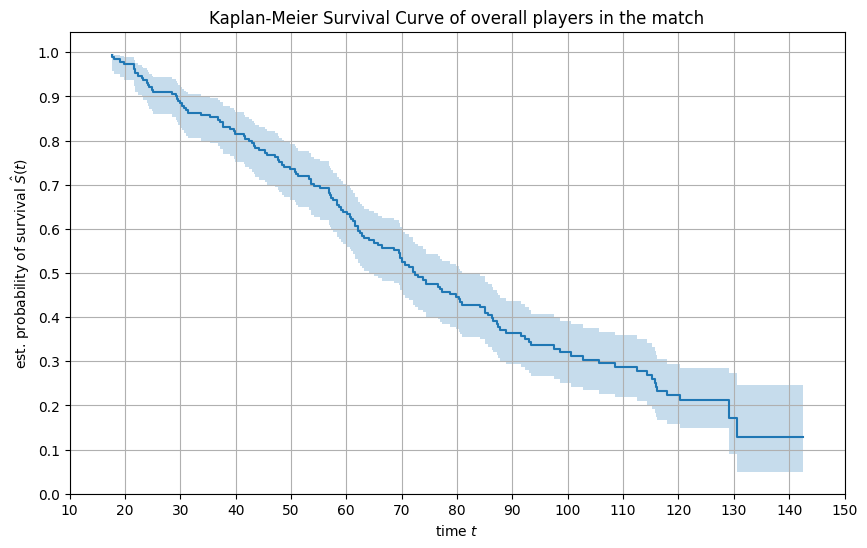

In [339]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

plt.figure(figsize=(10, 6))

time, survival_prob, conf_int = kaplan_meier_estimator(
    survival_data["died"], survival_data["seconds"], conf_type="log-log"
)

y_ticks = [x/100 for x in range(0, 110, 10)]
x_ticks = [x for x in range(0, 170, 10)]

plt.title("Kaplan-Meier Survival Curve of overall players in the match")
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.grid(True)
plt.xlabel("time $t$")
plt.yticks(y_ticks)
plt.xticks(x_ticks)
plt.xlim(10, 150)
plt.savefig('survival_curves/overall_survival_curve.png')
plt.show()


### Survival curve by team

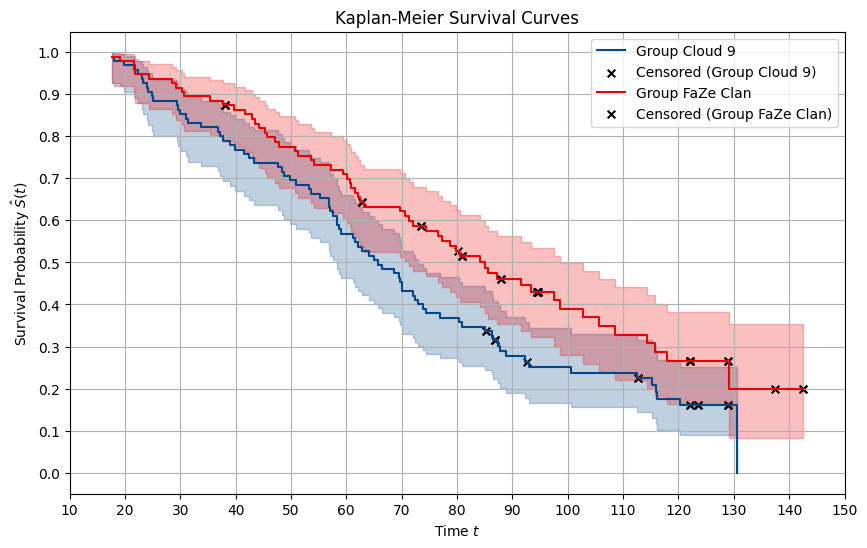

In [340]:
plt.figure(figsize=(10, 6))

# Lancet color palette
lancet_palette = ["#00468B", "#ED0000", "#42B540", "#0099B4", "#925E9F", "#FDAF91"]


# Iterate through each group
for i, group in enumerate(survival_data['user_team_clan_name'].unique()):
    # Filter data for the group
    group_data = survival_data[survival_data['user_team_clan_name'] == group]
    
    # Compute Kaplan-Meier estimator
    time, survival_prob, conf_int = kaplan_meier_estimator(
        group_data['died'], 
        group_data['seconds'],
        conf_type="log-log"
    )
    
    # Plot the survival curve
    plt.step(time, survival_prob, where="post", label=f"Group {group}", color = lancet_palette[i % len(lancet_palette)])

    # Add confidence intervals
    plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post", color = lancet_palette[i % len(lancet_palette)])

    # Add censored points
    censored_times = group_data[group_data['died'] == False]['seconds']
    censored_survival = [survival_prob[np.searchsorted(time, t, side="right") - 1] for t in censored_times]
    plt.scatter(censored_times, censored_survival, 
                color="black", s=30, marker = "x", label=f"Censored (Group {group})")

# Customize the plot
plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Time $t$")
plt.ylabel("Survival Probability $\hat{S}(t)$")
plt.legend()
plt.grid(True)
plt.yticks(y_ticks)
plt.xticks(x_ticks)
plt.xlim(10, 150)
plt.savefig('survival_curves/survival_by_team.png')
plt.show()

### Survival curve by Team/Side playing on

In [320]:
# first need to fill in missing team side values victim side only exists when they died
survival_data['clean_team'] = np.select(
    [
        (survival_data['victim_team_name'].isna()) & (survival_data['round'] <= 12) & (survival_data['user_team_clan_name'] == "FaZe Clan"),
        (survival_data['victim_team_name'].isna()) & (survival_data['round'] >= 12) & (survival_data['user_team_clan_name'] == "FaZe Clan"),
        (survival_data['victim_team_name'].isna()) & (survival_data['round'] <= 12) & (survival_data['user_team_clan_name'] == "Cloud 9"),
        (survival_data['victim_team_name'].isna()) & (survival_data['round'] >= 12) & (survival_data['user_team_clan_name'] == "Cloud 9")    
    ],
    [
        'CT',
        'TERRORIST',
        'TERRORIST',
        'CT'
    ],
    default =  survival_data['victim_team_name']
)


# now create an indicator of team name/ side
survival_data['team_side_identifier'] = survival_data['user_team_clan_name'] + "-" + survival_data["clean_team"]

C:\Users\goldp\AppData\Local\Temp\ipykernel_32668\2377659806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_data['clean_team'] = np.select(
C:\Users\goldp\AppData\Local\Temp\ipykernel_32668\2377659806.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_data['team_side_identifier'] = survival_data['user_team_clan_name'] + "-" + survival_data["clean_team"]


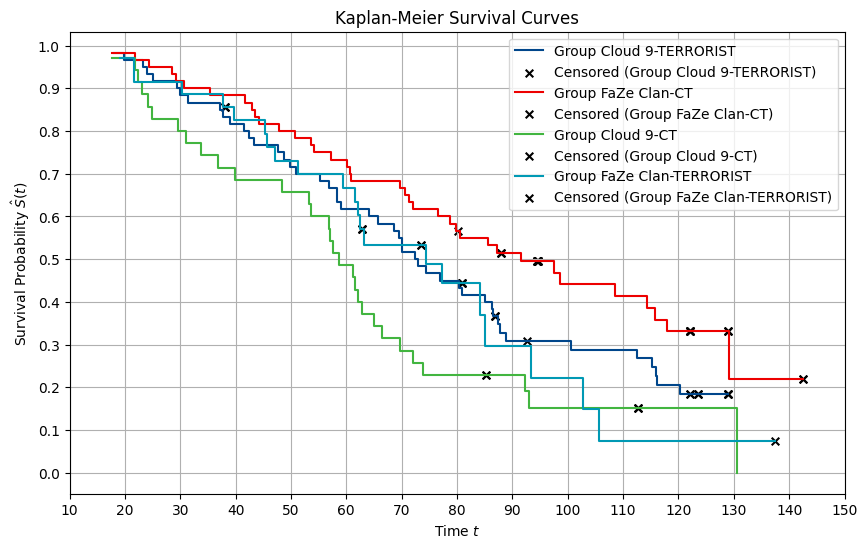

In [341]:
# now recreate Kaplan Meier curve with each team/side combo as own survival curve
# Initialize the plot
plt.figure(figsize=(10, 6))

for i, group in enumerate(survival_data['team_side_identifier'].unique()):
    # Filter data for the group
    group_data = survival_data[survival_data['team_side_identifier'] == group]
    
    # Compute Kaplan-Meier estimator
    time, survival_prob, conf_int = kaplan_meier_estimator(
        group_data['died'], 
        group_data['seconds'],
        conf_type="log-log"
    )
    
    # Plot the survival curve
    plt.step(time, survival_prob, where="post", label=f"Group {group}", color = lancet_palette[i % len(lancet_palette)])

    # Add censored points
    censored_times = group_data[group_data['died'] == False]['seconds']
    censored_survival = [survival_prob[np.searchsorted(time, t, side="right") - 1] for t in censored_times]
    plt.scatter(censored_times, censored_survival, 
                color="black", s=30, marker = "x", label=f"Censored (Group {group})")


# Customize the plot
# plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Time $t$")
plt.ylabel("Survival Probability $\hat{S}(t)$")
plt.legend()
plt.grid(True)
plt.yticks(y_ticks)
plt.xticks(x_ticks)
plt.xlim(10, 150)
plt.savefig('survival_curves/survival_by_team_side.png')
plt.show()

### Each team by side

#### Cloud 9

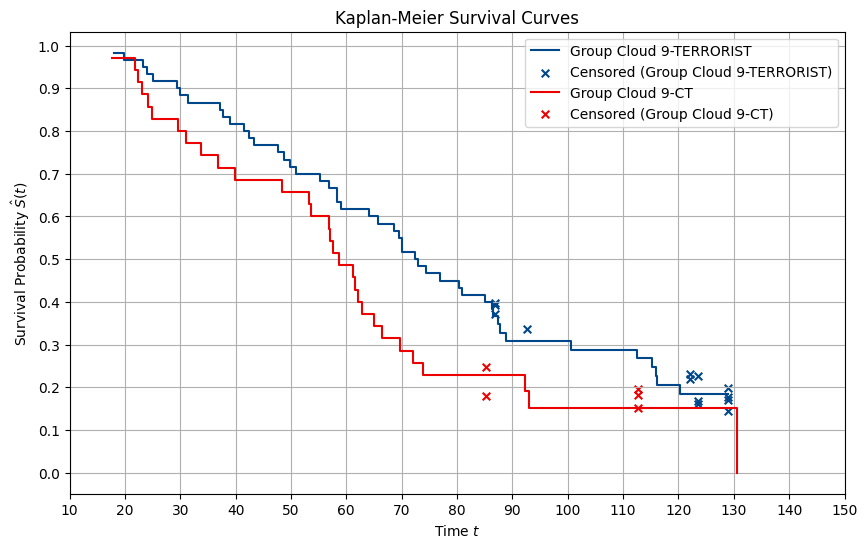

In [342]:
# make Cloud 9 survival data
c9_survival = survival_data[survival_data['user_team_clan_name'] == "Cloud 9"]

plt.figure(figsize=(10,6))

# add jitter to points to distinguish between multiple censors at one time
jitter_strength = 0.05

for i, group in enumerate(c9_survival['team_side_identifier'].unique()):
    # Filter data for the group
    group_data = c9_survival[c9_survival['team_side_identifier'] == group]
    
    # Compute Kaplan-Meier estimator
    time, survival_prob, conf_int = kaplan_meier_estimator(
        group_data['died'], 
        group_data['seconds'],
        conf_type="log-log"
    )
    
    # Plot the survival curve
    plt.step(time, survival_prob, where="post", label=f"Group {group}", color = lancet_palette[i % len(lancet_palette)])

    # Add censored points
    censored_times = group_data[group_data['died'] == False]['seconds']
    censored_survival = [survival_prob[np.searchsorted(time, t, side="right") - 1] for t in censored_times]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, len(censored_times))
    plt.scatter(censored_times, censored_survival + jitter, 
                color=lancet_palette[i % len(lancet_palette)], s=30, marker = "x", label=f"Censored (Group {group})")


# Customize the plot
plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Time $t$")
plt.ylabel("Survival Probability $\hat{S}(t)$")
plt.legend()
plt.grid(True)
plt.yticks(y_ticks)
plt.xticks(x_ticks)
plt.xlim(10, 150)
plt.savefig('survival_curves/survival_cloud_9.png')
plt.show()

#### FaZe

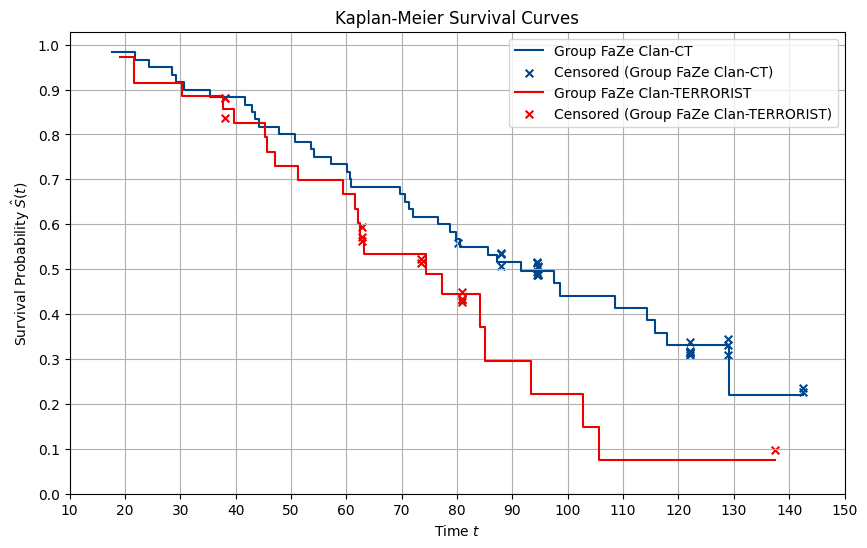

In [343]:
# make FaZe survival data
fz_survival = survival_data[survival_data['user_team_clan_name'] == "FaZe Clan"]

plt.figure(figsize=(10,6))

# add jitter to points to distinguish between multiple censors at one time
jitter_strength = 0.025

for i, group in enumerate(fz_survival['team_side_identifier'].unique()):
    # Filter data for the group
    group_data = fz_survival[fz_survival['team_side_identifier'] == group]
    
    # Compute Kaplan-Meier estimator
    time, survival_prob, conf_int = kaplan_meier_estimator(
        group_data['died'], 
        group_data['seconds'],
        conf_type="log-log"
    )
    
    # Plot the survival curve
    plt.step(time, survival_prob, where="post", label=f"Group {group}", color = lancet_palette[i % len(lancet_palette)])

    # Add censored points
    censored_times = group_data[group_data['died'] == False]['seconds']
    censored_survival = [survival_prob[np.searchsorted(time, t, side="right") - 1] for t in censored_times]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, len(censored_times))
    plt.scatter(censored_times, censored_survival + jitter, 
                color=lancet_palette[i % len(lancet_palette)], s=30, marker = "x", label=f"Censored (Group {group})")


# Customize the plot
plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Time $t$")
plt.ylabel("Survival Probability $\hat{S}(t)$")
plt.legend()
plt.grid(True)
plt.yticks(y_ticks)
plt.xticks(x_ticks)
plt.xlim(10, 150)
plt.savefig('survival_curves/survival_faze.png')
plt.show()

### Discussion

Some interesting patterns emerge while examining the survival curves of the two teams. The first observation is that the first death for both teams occurs right around the 20 second mark. The second is that FaZe has a higher probability of survival as the round goes on. Lastly, around 130 seconds both teams have a minor drop, but FaZe does not fall to 0.


Investigating this pattern and looking at Cloud 9's survival curves for their CT side, we see that at around 75 seconds it flattens off, with a minor drop to another flat period at 95 seconds. As CS rounds have 115 seconds of normal play with an additional 45 seconds if the opponent plants the bomb, then we know that any time period past 115 seconds is a bomb plant scenario. Using this, the conclusion seems like Cloud 9 did not generally attempt to re-take the site after FaZe planted and saved their equipment for the next round. If Cloud 9 did attempt a re-take, then it happened at roughly around 90 seconds and was seemingly unsucessful, as the surival curve drops again or they were eliminated with the bomb.


Examining FaZe Clan's survival curves by side, we find similar yet less extreme patterns as Cloud 9 for their T side. On the T side, FaZe had an extended period of staying alive, while on the CT side they fell off shortly - unlike Cloud 9. 


There are also might be a relationship between CT and T survival curves, such that when FaZe was on CT side, they had a higher probability of survival than their T side, and the opposite is true for Cloud 9's half. I wonder if this is just two sides of the same coin. If one team does one well on their T side, the other *must* do poorly on their CT side, and vice versa. More matches should be examined to investigate this pattern further, though intuitively it makes sense. I could also see a situation in which a team is *so* dominant on both sides that both of their side curves are equal and above the other teams.


---

Next I would like to attempt to build an Accelerated Failure Time model, to try to find some factors that affect a players time alive.

## Accelerated Failure Time model

In [360]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()

aft.fit(survival_data[['seconds', 'died']], duration_col='seconds', event_col='died')

aft.summary

,,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
param,covariate,,,,,,,,,,,
lambda_,Intercept,4.540227,93.712114,0.044612,4.452790,4.627665,85.866176,102.274967,0.0,101.771948,0.000000e+00,inf
rho_,Intercept,0.653865,1.922959,0.071433,0.513858,0.793872,1.671729,2.211945,0.0,9.153488,5.512436e-20,63.975872
